## Импортируем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
from kaggle_environments import make, evaluate
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузим в файлы наших агентов

In [2]:
%%writefile rock.py

def rock(observation, configuration):
    return 0

Overwriting rock.py


In [3]:
%%writefile paper.py
def paper(observation, configuration):
    return 1

Overwriting paper.py


In [4]:
%%writefile scissors.py
def scissors(observation, configuration):
    return 2

Overwriting scissors.py


In [5]:
%%writefile copy_opponent.py

import random

def copy_opponent(observation, configuration):
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return random.randrange(0, configuration.signs)

Overwriting copy_opponent.py


In [6]:
%%writefile reactionary.py

import random
import math


def get_score(left_move, right_move):
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

last_react_action = None

def reactionary(observation, configuration):
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)
    elif get_score(last_react_action, observation.lastOpponentAction) <= 1:
        last_react_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_react_action

Overwriting reactionary.py


In [7]:
%%writefile counter_reactionary.py

import random
import math

last_counter_action = None

def get_score(left_move, right_move):
    # This method exists in this file so it can be consumed from rps.py and agents.py without a circular dependency
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

def counter_reactionary(observation, configuration):
    global last_counter_action
    if observation.step == 0:
        last_counter_action = random.randrange(0, configuration.signs)
    elif get_score(last_counter_action, observation.lastOpponentAction) == 1:
        last_counter_action = (last_counter_action + 2) % configuration.signs
    else:
        last_counter_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_counter_action

Overwriting counter_reactionary.py


In [8]:
%%writefile statistical.py

import random

action_histogram = {}

def statistical(observation, configuration):
    global action_histogram
    if observation.step == 0:
        action_histogram = {}
        return
    action = observation.lastOpponentAction
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs

Overwriting statistical.py


In [9]:
%%writefile nash_equilibrium_agent.py

import random

def nash_equilibrium_agent(observation, configuration):
    return random.randint(0, 2)

Overwriting nash_equilibrium_agent.py


In [10]:
%%writefile markov_agent.py

import numpy as np
import collections
import random

def markov_agent(observation, configuration):
    k = 2
    global table, action_seq
    if observation.step % 250 == 0: # refresh table every 250 steps
        action_seq, table = [], collections.defaultdict(lambda: [1, 1, 1])    
    if len(action_seq) <= 2 * k + 1:
        action = int(np.random.randint(3))
        if observation.step > 0:
            action_seq.extend([observation.lastOpponentAction, action])
        else:
            action_seq.append(action)
        return action
    # update table
    key = ''.join([str(a) for a in action_seq[:-1]])
    table[key][observation.lastOpponentAction] += 1
    # update action seq
    action_seq[:-2] = action_seq[2:]
    action_seq[-2] = observation.lastOpponentAction
    # predict opponent next move
    key = ''.join([str(a) for a in action_seq[:-1]])
    if observation.step < 500:
        next_opponent_action_pred = np.argmax(table[key])
    else:
        scores = np.array(table[key])
        next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum()) # add stochasticity for second part of the game
    # make an action
    action = (next_opponent_action_pred + 1) % 3
    # if high probability to lose -> let's surprise our opponent with sudden change of our strategy
    if observation.step > 900:
        action = next_opponent_action_pred
    action_seq[-1] = action
    return int(action)

Overwriting markov_agent.py


In [11]:
%%writefile transition_agent.py

import numpy as np
import pandas as pd
import random

T = np.zeros((3, 3))
P = np.zeros((3, 3))

a1, a2 = None, None

def transition_agent(observation, configuration):
    global T, P, a1, a2
    if observation.step > 1:
        a1 = observation.lastOpponentAction
        T[a2, a1] += 1
        P = np.divide(T, np.maximum(1, T.sum(axis=1)).reshape(-1, 1))
        a2 = a1
        if np.sum(P[a1, :]) == 1:
            return int((np.random.choice(
                [0, 1, 2],
                p=P[a1, :]
            ) + 1) % 3)
        else:
            return int(np.random.randint(3))
    else:
        if observation.step == 1:
            a2 = observation.lastOpponentAction
        return int(np.random.randint(3))

Overwriting transition_agent.py


In [12]:
%%writefile rock_paper.py

import random

def rock_paper(observation, configuration):
    return random.randint(0, 1)

Overwriting rock_paper.py


In [13]:
%%writefile paper_scissors.py

import random

def paper_scissors(observation, configuration):
    return random.randint(1, 2)

Overwriting paper_scissors.py


## Реализация поединка

In [14]:
# Сохраним агентов в список
agents = [
    "rock",
    "paper",
    "scissors",
    "copy_opponent",
    "reactionary",
    "counter_reactionary",
    "statistical",
    "nash_equilibrium_agent",
    "markov_agent",
    "transition_agent",
    "rock_paper",
    "paper_scissors"
]

In [15]:
# Добавим к имени каждого агента расширение .py
lst_a = [i + ".py" for i in agents]
lst_a

['rock.py',
 'paper.py',
 'scissors.py',
 'copy_opponent.py',
 'reactionary.py',
 'counter_reactionary.py',
 'statistical.py',
 'nash_equilibrium_agent.py',
 'markov_agent.py',
 'transition_agent.py',
 'rock_paper.py',
 'paper_scissors.py']

In [16]:
# Создадим переменную для хранения длины списка с агентами
num_agents = len(agents)
num_agents

12

In [17]:
# Создадим нулевую матрицу, в которую мы будем записывать результаты наших игр
scores = np.zeros((num_agents, num_agents))
scores

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [18]:
# Запишем результаты наших игр через цикл в созданную нулевую матрицу
for i in range(num_agents):
    for j in range(i + 1, num_agents):
        
        result = evaluate(
            "rps", 
            [lst_a[i], lst_a[j]], 
            configuration={"episodeSteps": 100},
            num_episodes = 1
            )
        
        scores[i, j] = result[0][0]
        scores[j, i] = result[0][1]

In [19]:
# Сохраним наши значения в ДатаФрейме
df = pd.DataFrame(scores, index=agents, columns=agents)
df

,rock,paper,scissors,copy_opponent,reactionary,counter_reactionary,statistical,nash_equilibrium_agent,markov_agent,transition_agent,rock_paper,paper_scissors
rock,0.0,-99.0,99.0,0.0,-99.0,-50.0,-98.0,0.0,-94.0,-98.0,-51.0,0.0
paper,99.0,0.0,-99.0,0.0,-99.0,-49.0,-97.0,0.0,-83.0,-97.0,49.0,-46.0
scissors,-99.0,99.0,0.0,0.0,-97.0,-48.0,-99.0,0.0,-72.0,-99.0,0.0,56.0
copy_opponent,0.0,0.0,0.0,0.0,-50.0,99.0,-21.0,0.0,-76.0,0.0,0.0,0.0
reactionary,99.0,99.0,97.0,50.0,0.0,-97.0,49.0,0.0,-73.0,0.0,26.0,25.0
counter_reactionary,50.0,49.0,48.0,-99.0,97.0,0.0,0.0,0.0,-76.0,-95.0,0.0,0.0
statistical,98.0,97.0,99.0,21.0,-49.0,0.0,0.0,0.0,-34.0,-36.0,0.0,0.0
nash_equilibrium_agent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
markov_agent,94.0,83.0,72.0,76.0,73.0,76.0,34.0,0.0,0.0,0.0,43.0,0.0
transition_agent,98.0,97.0,99.0,0.0,0.0,95.0,36.0,0.0,0.0,0.0,0.0,27.0


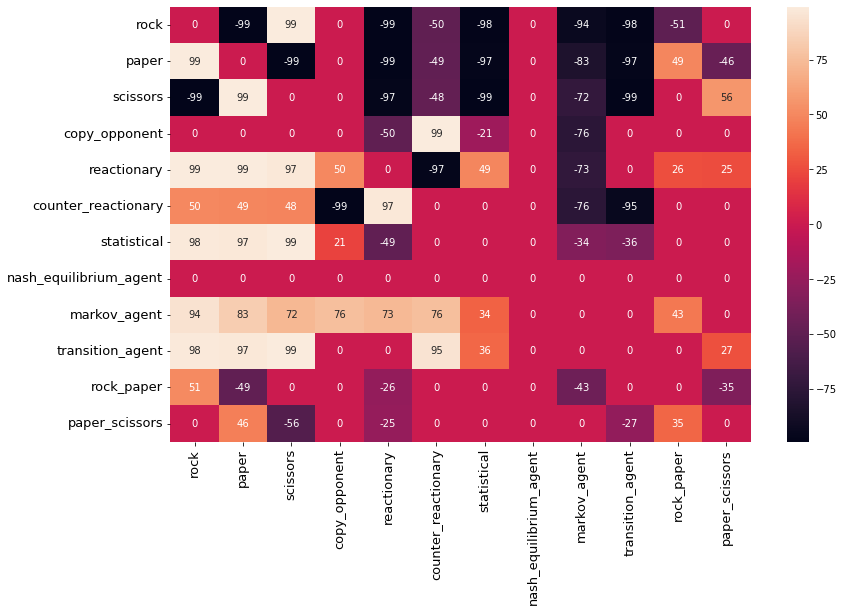

In [20]:
# построим тепловую матрицу для наглядности результатов
plt.figure(figsize=(13, 8))
sns.heatmap(df, annot=True)
plt.xticks(rotation=90, fontsize=13)
plt.yticks(fontsize=13);